In [45]:
import numpy as np
import scanpy.api as sc
import pandas as pd
import pylab
import matplotlib.pyplot as plt
from collections import Counter
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import os
import gseapy

from ete3 import Tree

import pickle as pic

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.stats.multitest as multi

import scipy.stats as scs

from tqdm import tqdm_notebook

np.set_printoptions(threshold=np.nan)

from utilities import de_utils

## Read in 10X data matrix & pre-process data

In [2]:
path = "/home/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/GRCh38/"
adata = sc.read(path + "matrix.mtx", cache=True).T
genes = pd.read_csv(path + "genes.tsv", header=None, sep='\t')
adata.var_names = genes[1]
adata.var['gene_ids'] = genes[0]  # add the gene ids as annotation of the variables/genes
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
adata.var_names_make_unique()

all_genes = adata.var_names

meta = pd.read_csv("data/5k.LG_meta.txt", sep='\t', index_col=0)
latent = pd.read_csv("/home/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/latent.csv", sep='\t', index_col = 0).as_matrix()
gene_list = pd.read_csv("/home/mattjones/projects/metastasis/JQ19/5k/RNA/AGGR/filter_gene_list.txt", sep='\t', index_col = 0, header=None).values

adata.shape, latent.shape, meta.shape 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


((43423, 33694), (43423, 10), (40969, 7))

In [3]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
adata.obs['percent_mito'] = np.sum(adata[:,mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['nUMI'] = adata.X.sum(axis=1).A1
adata.obs['n_genes'] = np.sum(adata.X > 0, axis=1).A1

adata.obs = adata.obs.merge(meta, left_index = True, right_index=True, how="left")


In [4]:
adata.raw = sc.pp.log1p(adata, copy=True)

In [5]:
scale_factor = np.median(np.array(adata.X.sum(axis=1)))
sc.pp.normalize_per_cell(adata, counts_per_cell_after = scale_factor)

In [6]:
filter_result = list(map(lambda x: x in gene_list, adata.var_names))
# sc.pl.filter_genes_dispersion(filter_result)
adata = adata[:, filter_result]

In [7]:
sc.pp.log1p(adata)

In [8]:
## we've already computed a latent space so we don't need to regress out these features. However, Scanpy won't recognize the X_pca field without it.

sc.pp.regress_out(adata, ["nUMI"], n_jobs = 10)

... storing 'sampleID' as categorical
... storing 'Sample2' as categorical
... storing 'gene_ids' as categorical


## Perform dimensionality reduction & visualization

In [17]:
sc.tl.pca(adata, n_comps=30)

# adata.obsm["X_pca"] = latent

In [19]:
sc.tl.tsne(adata, random_state=2, n_pcs=10, n_jobs = 10)

In [20]:
sc.pp.neighbors(adata, n_neighbors = int(np.sqrt(adata.X.shape[0])))
sc.tl.umap(adata)

In [21]:
sc.tl.louvain(adata)

### Filter our cells not observed in the multiseq library

In [22]:
meta_filter = np.logical_not(adata.obs["LineageGroup"].isna())
adata = adata[meta_filter, :]

<Figure size 504x504 with 0 Axes>

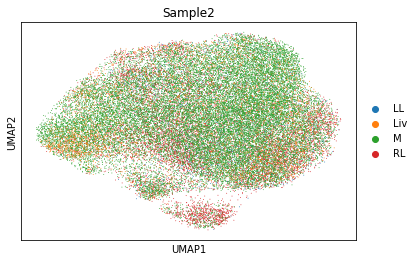

<Figure size 504x504 with 0 Axes>

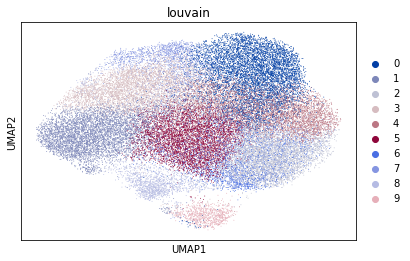

In [23]:
h = plt.figure(figsize=(7,7))
ax = sc.pl.umap(adata, color='Sample2', show=True)

h = plt.figure(figsize = (7,7))
ax = sc.pl.umap(adata, color = "louvain", show = True)

## Get Correlates of Metastatic Ability

In [25]:
met_scores = pd.read_csv("data/lg_metastatic_scores.txt", sep='\t', index_col = 0)
sig_scores = pd.read_csv("../JQ19/5k/RNA/JQ19.sigscores.txt", sep='\t', index_col = 0)

In [27]:
keep_cells = np.intersect1d(sig_scores.index, adata.obs_names)

sig_scores_subset = sig_scores.loc[keep_cells]

In [31]:
for sig in tqdm_notebook(sig_scores_subset.columns):
    met_scores[sig] = 0
    for lg, g in meta.groupby("LineageGroup"):
        if int(lg) not in met_scores.index:
            continue
    #for lg in met_scores.index:
        cells = g.index

        met_scores.loc[lg, sig] = np.mean(sig_scores_subset.loc[cells, sig])

/home/mattjones/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [33]:
corrs = []
ks_stats = []

signif_sigs = []
for sig in tqdm_notebook(sig_scores_subset.columns):
    
    pcorr = scs.pearsonr(met_scores[sig], met_scores["Dynamic"])[0]    
    #ks = scs.ks_2samp(met_scores[sig], met_scores["Evolving"])[0]
    if abs(pcorr) > 0.4:
        signif_sigs.append(sig)
    corrs.append(pcorr)

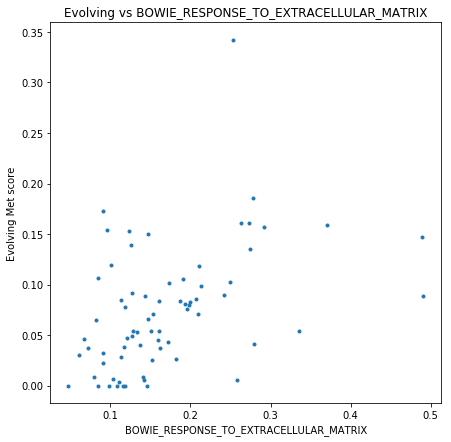

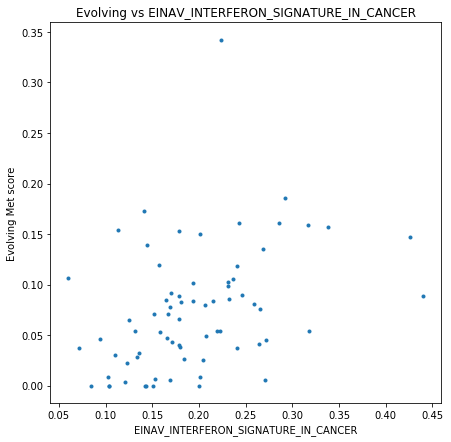

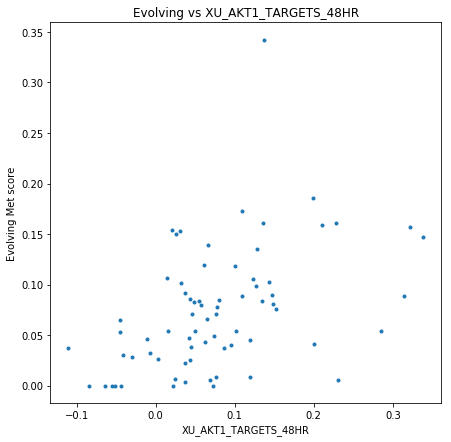

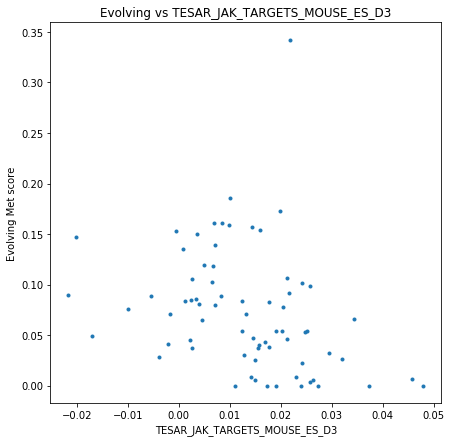

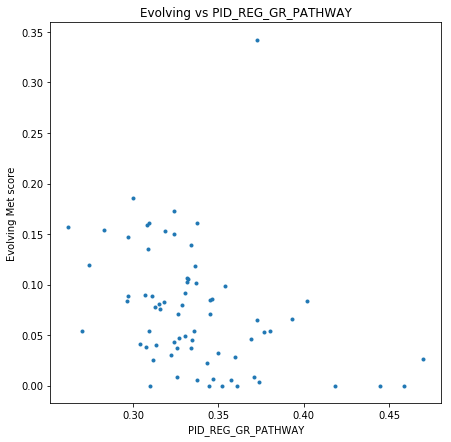

In [35]:
for sig in ["BOWIE_RESPONSE_TO_EXTRACELLULAR_MATRIX", "EINAV_INTERFERON_SIGNATURE_IN_CANCER", "XU_AKT1_TARGETS_48HR", "TESAR_JAK_TARGETS_MOUSE_ES_D3", "PID_REG_GR_PATHWAY"]:
    h = plt.figure(figsize = (7,7))
    plt.plot(met_scores[sig], met_scores["Dynamic"], ".")
    plt.title("Evolving vs " + sig)
    plt.xlabel(sig)
    plt.ylabel("Evolving Met score")
    # plt.savefig(sig + "_evomet_corr.pdf")

### Run genewise analysis with pseudobulk 

In [67]:
lg_groups = [[]]*101
for n, g in adata.obs.groupby("LineageGroup"):
    lg_groups[int(n)] = g.index
    
agg_counts = np.zeros((adata.X.shape[1], 100))
for j in tqdm_notebook(range(agg_counts.shape[1]), desc="pooling cells"):

    lg = lg_groups[j+1]
    filt = list(map(lambda x: x in lg, adata.obs_names))
    lg_counts = np.mean(adata[filt,:].X, axis=0)
    
    agg_counts[:,j] = lg_counts
    
lg_adata = sc.AnnData(agg_counts.T)
lg_adata.obs_names = range(1,101)
lg_adata.var_names = adata.var_names
lg_adata.obs["dynamic"] = met_scores.loc[lg_adata.obs_names, "Dynamic"]
lg_adata.obs["static"] = met_scores.loc[lg_adata.obs_names, "Static"]

meta_filter = np.logical_not(lg_adata.obs["dynamic"].isna())
lg_adata = lg_adata[meta_filter,:]
lg_adata.obs.shape

AnnData expects string indices for some functionality, but your first two indices are: range(1, 3). 


(71, 2)

In [68]:
hallmark_sigs = gseapy.parser.gsea_gmt_parser("/home/mattjones/data/h.all.v5.2.symbols.gmt")
c2_sigs = gseapy.parser.gsea_gmt_parser("/home/mattjones/data/c2.all.v6.0.symbols.gmt")
c6_sigs = gseapy.parser.gsea_gmt_parser("/home/mattjones/data/c6.all.v6.0.symbols.gmt")

all_sigs = {**hallmark_sigs, **c2_sigs, **c6_sigs}

In [69]:
gene_counter = {}
for sig in tqdm_notebook(signif_sigs, desc="trying significant signatures"):
    
    if sig not in all_sigs:
        up_sig, dn_sig = sig + "_UP", sig + "_DN"
        if up_sig in all_sigs:
            res, up_genes = de_utils.run_lin_reg(lg_adata, all_sigs[up_sig], 'dynamic')
        if dn_sig in all_sigs:
            res, down_genes = de_utils.run_lin_reg(lg_adata, all_sigs[dn_sig], 'dynamic')
        
        genes = up_genes + down_genes
    else:
        res, genes = de_utils.run_lin_reg(lg_adata, all_sigs[sig], 'dynamic')

    for g in genes:
        if g not in gene_counter:
            gene_counter[g] = 0
        gene_counter[g] += 1
        
df = pd.DataFrame.from_dict(gene_counter, orient="index")

<Figure size 504x504 with 0 Axes>

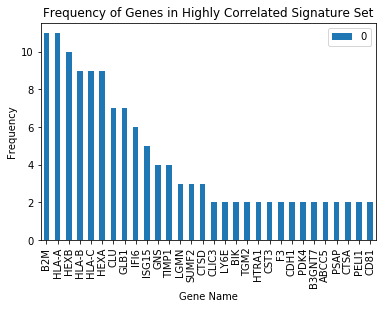

In [72]:
h = plt.figure(figsize=(7,7))
df.sort_values(by=0, ascending=False).head(30).plot(kind='bar')
plt.title("Frequency of Genes in Highly Correlated Signature Set")
plt.xlabel("Gene Name")
plt.ylabel("Frequency")
plt.savefig("figs/gene_freq_corrsigs.pdf")

In [75]:
all_pvalues, all_betas, all_corr = de_utils.run_lin_reg_ALL_GENES(lg_adata, 'dynamic')

genedf = pd.DataFrame.from_dict(all_pvalues, orient="index", columns=['pvalues'])
genedf["betas"] = list(map(lambda x: all_betas[x], all_pvalues.keys()))
genedf["Corr"] = list(map(lambda x: all_corr[x], all_pvalues.keys()))
genedf["Adjusted P-values"] = multi.multipletests(genedf["pvalues"], alpha=0.05, method='fdr_bh')[1]

genedf.sort_values(by="Adjusted P-values", ascending=True).head()

#genedf.to_csv("evolving_score_prediction.txt", sep='\t')

100%|██████████| 7586/7586 [00:05<00:00, 1463.49it/s]


,pvalues,betas,Corr,Adjusted P-values
PDK4,5.009614e-07,1.239388,0.555288,0.003534
CLU,9.317750e-07,2.379008,0.544215,0.003534
CD9,4.918853e-06,1.019473,0.512418,0.012438
SUMF2,1.665281e-05,0.799855,0.486891,0.031582
PIGT,2.651612e-05,0.903366,0.476589,0.034209


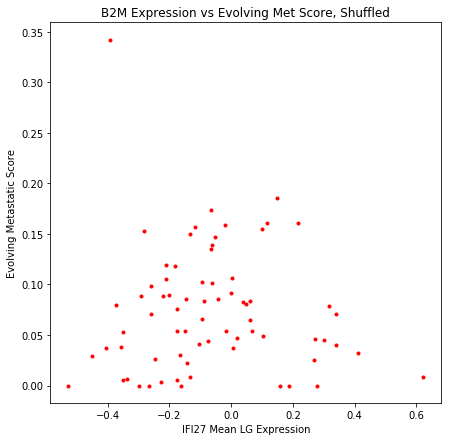

In [77]:
for gene in ["B2M", "IFI6", "SEPP1", "FXYD3", "ISG15", "DMKN", "ZNF605", "MX1", 'IFI27']:
    
    plt.close()
    
    h = plt.figure(figsize=(7,7))
    plt.plot(lg_adata.X[:,(lg_adata.var_names == gene)][:,0], lg_adata.obs["dynamic"], 'r.')
    plt.xlabel(gene + " Mean LG Expression")
    plt.ylabel("Evolving Metastatic Score")
    plt.title(gene + " Expression vs Evolving Met Score")
    # plt.show()
    #plt.savefig(gene + "_vs_evomet.pdf")

evoarr = lg_adata.obs["dynamic"].values
evoarr = np.random.permutation(evoarr)
plt.close()
# plot shuffled gene list 
h = plt.figure(figsize=(7,7))
plt.plot(lg_adata.X[:,(lg_adata.var_names == "B2M")][:,0], evoarr, 'r.')
plt.xlabel(gene + " Mean LG Expression")
plt.ylabel("Evolving Metastatic Score")
plt.title("B2M" + " Expression vs Evolving Met Score, Shuffled")
plt.show()